# Install Libraries

In [1]:
!pip install tensorflow pandas numpy sklearn
!pip install pandas scikit-learn
!pip install lime shap
!pip install scikeras

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=ea2805cc8778d9f3031399fe67f9a849976bcf8b3125c0976f3ced3d0325199c
  Stored in directory: /root/.cache/pip/wheels/aa/9c/60/f67813603a52fc35057868f1aba0003cc75b72583dcaa2c341
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 15.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0bd03e747a61d7063452fd6c998a38dca0f333321dda74d50d4b3fa6c2959aac
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from keras.layers import SimpleRNN, Dense
import random
import tensorflow as tf
from google.colab import drive

# Read Preprocessed Data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
file_path_AU_preprocessed = '/content/drive/MyDrive/CKD/Current/data/preprocessed/AU/AU_preprocessed_df.csv'
file_path_JP_preprocessed = '/content/drive/MyDrive/CKD/Current/data/preprocessed/JP/JP_preprocessed_df.csv'

# Train and Evaluate Models

### TUNED HYPERAMETER MODEL - AU Dataset

In [15]:
# Read Data
AU_df = pd.read_csv(file_path_AU_preprocessed)
AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
AU_df = AU_df.reset_index(drop=True)

# Normalize the numeric columns
scaler = MinMaxScaler()
AU_df[['AGE', 'eGFR']] = scaler.fit_transform(AU_df[['AGE', 'eGFR']])

# Filter UIDs with sequences >= 3
grouped = AU_df.groupby(['ID', 'Kidney_Failure']).size().unstack(fill_value=0)
grouped = grouped[(grouped[1] >= 0) | (grouped[0] >= 0)] #3

# List of columns to drop
cols_to_drop = ['ID', 'Kidney_Failure', 'COLLECTED']  # add other non-numeric columns if present

X = pad_sequences(AU_df.groupby('ID').apply(lambda group: group.drop(cols_to_drop, axis=1).to_numpy()).tolist(), maxlen=50, dtype='float32', padding='post')
y = AU_df.groupby('ID')['Kidney_Failure'].first().to_numpy()

# Initialise class weights
class_counts = np.bincount(y)
total_samples = np.sum(class_counts)
class_weights = {0: total_samples / (class_counts[0] + 1), 1: total_samples / (class_counts[1] + 1)}

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Set random seeds
seed_value = 0
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
                                   'TPR', 'TNR', 'FPR', 'FNR',
                                   'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# Function to create the model, required for KerasClassifier
def create_model(lr=0.001):
    # Create model
    model = Sequential()
    model.add(SimpleRNN(units=3, input_shape=(50, 3), return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=Precision())
    return model

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, lr=0.001, verbose=1)

# Define the grid search parameters
param_grid = {
    #'epochs': [10, 50],
    #'batch_size': [32, 128],
    'model__lr': [0.001, 0.01, 0.1] # Prefix with 'model__' to denote it's a parameter for the model-building function
}

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', n_jobs=-1, cv=3)

grid_result = grid.fit(X, y)

# Output the best parameters and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


79/79 [==============================] - 2s 13ms/step - loss: 0.4638 - precision_1: 0.0421
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 0.3225 - precision_1: 0.0000e+00
Epoch 3/20
79/79 [==============================] - 1s 16ms/step - loss: 0.2626 - precision_1: 0.0000e+00
Epoch 4/20
79/79 [==============================] - 1s 14ms/step - loss: 0.2276 - precision_1: 0.0000e+00
Epoch 5/20
79/79 [==============================] - 1s 14ms/step - loss: 0.2043 - precision_1: 0.0000e+00
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.1879 - precision_1: 0.0000e+00
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.1756 - precision_1: 0.0000e+00
Epoch 8/20
79/79 [==============================] - 1s 14ms/step - loss: 0.1664 - precision_1: 0.0000e+00
Epoch 9/20
79/79 [==============================] - 1s 9ms/step - loss: 0.1601 - precision_1: 0.0000e+00
Epoch 10/20
79/79 [==============================] - 1s 9ms/st

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
                                   'TPR', 'TNR', 'FPR', 'FNR',
                                   'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# Use Stratified KFold for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define the model
    model = Sequential()
    model.add(SimpleRNN(units=3, input_shape=(50, 3), return_sequences=False)) #50, 4 !CHECK
    model.add(Dense(1, activation = 'sigmoid')) # This is just a linear combination

    # Compile the model
    precision = Precision(thresholds=threshold)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision])
    model.summary()

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=128, class_weight=class_weights)
    print(class_weights)

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test)

    # Get the predictions
    predictions = model.predict(X_test)
    predicted_labels = (predictions >= threshold).astype(int).flatten()

    # Compute the statistics
    true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
    true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
    false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
    false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = (true_positives + true_negatives) / len(y_test)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = 2 * precision * recall / (precision + recall)
    specificity = true_negatives / (true_negatives + false_positives)
    roc_auc = roc_auc_score(y_test, predictions)

    print(accuracy, precision, recall, f1, specificity, roc_auc)

    # Add the statistics to the dataframe
    df_results.loc[len(df_results)] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, f1, specificity, roc_auc]

# Print the average of each statistic over the 5 folds
mean_results = df_results.mean()
std_results = df_results.std()

# Create a new DataFrame to display mean and standard deviation
results_summary = pd.DataFrame(index=mean_results.index)
results_summary['Mean'] = mean_results
results_summary['Standard Deviation'] = std_results

print(results_summary)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
63/63 [==============================] - 2s 15ms/step - loss: 1.3509 - precision_2: 0.0550
Epoch 2/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3358 - precision_2: 0.0541
Epoch 3/50
63/63 [==============================] - 1s 16ms/step - loss: 1.3320 - precision_2: 0.0519
Epoch 4/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3178 - precision_2: 0.0574
Epoch 

In [18]:
# Train the final model on the full Australian dataset

import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.metrics import Precision

# Set random seeds for reproducibility
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Define the RNN model for the entire dataset
model = Sequential()
model.add(SimpleRNN(units=3, input_shape=(50, 3), return_sequences=False))
model.add(Dense(1, activation='sigmoid')) # This is a binary classification output

# Compile the model
precision = Precision(thresholds=threshold)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision])

# Fit the model on the entire dataset
model.fit(X, y, epochs=50, batch_size=128, class_weight=class_weights)

Epoch 1/50
79/79 [==============================] - 2s 10ms/step - loss: 1.3605 - precision_7: 0.0496
Epoch 2/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3449 - precision_7: 0.0546
Epoch 3/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3318 - precision_7: 0.0580
Epoch 4/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3214 - precision_7: 0.0607
Epoch 5/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3007 - precision_7: 0.0713
Epoch 6/50
79/79 [==============================] - 1s 9ms/step - loss: 1.2836 - precision_7: 0.0674
Epoch 7/50
79/79 [==============================] - 1s 9ms/step - loss: 1.2524 - precision_7: 0.0915
Epoch 8/50
79/79 [==============================] - 1s 9ms/step - loss: 1.2375 - precision_7: 0.1011
Epoch 9/50
79/79 [==============================] - 1s 9ms/step - loss: 1.2227 - precision_7: 0.0987
Epoch 10/50
79/79 [==============================] - 1s 9ms/step - loss: 1.2064 - precisio

### HELD-OUT TEST DATA - Tuned Model (Without Fine-Tuning)

In [ ]:
from pandas.tseries.offsets import DateOffset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

JP_df = pd.read_csv(file_path_JP_preprocessed)
JP_df = JP_df.reset_index(drop=True)

# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Apply the function to the 'Time' column to create a new 'Months' column
JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

# Assume a starting date for all IDs
start_date = pd.Timestamp('2020-01-01')

# Create a 'COLLECTED' column based on the 'Months' column
JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

#JP_df.drop(['Time', 'Months'], inplace = True)

# Normalize the numeric columns
scaler = MinMaxScaler()
JP_df[['AGE', 'eGFR']] = scaler.fit_transform(JP_df[['AGE', 'eGFR']])

# Filter UIDs with sequences >= 3
grouped = JP_df.groupby(['ID', 'Kidney_Failure']).size().unstack(fill_value=0)
grouped = grouped[(grouped[1] >= 0) | (grouped[0] >= 0)] #3

# List of columns to drop
cols_to_drop = ['ID', 'Kidney_Failure', 'COLLECTED', 'Time', 'Months']  # add other non-numeric columns if present

X = pad_sequences(JP_df.groupby('ID').apply(lambda group: group.drop(cols_to_drop, axis=1).to_numpy()).tolist(), maxlen=50, dtype='float32', padding='post')
y = JP_df.groupby('ID')['Kidney_Failure'].first().to_numpy()

# Initialise class weights
class_counts = np.bincount(y)
total_samples = np.sum(class_counts)
class_weights = {0: total_samples / (class_counts[0] + 1), 1: total_samples / (class_counts[1] + 1)}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score
import random

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Evaluate on the held-out test set
#clf = best_clf

# Evaluate the model on the test set
# loss = model.evaluate(X, y)

y_pred = model.predict(X)

predicted_labels = (y_pred >= threshold).astype(int).flatten()

# Compute the statistics
true_positives = np.sum((predicted_labels == 1) & (y == 1))
true_negatives = np.sum((predicted_labels == 0) & (y == 0))
false_positives = np.sum((predicted_labels == 1) & (y == 0))
false_negatives = np.sum((predicted_labels == 0) & (y == 1))

tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = (true_positives + true_negatives) / len(y)
precision = precision_score(y, predicted_labels)
recall = recall_score(y, predicted_labels)
f1 = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y, predicted_labels)
#roc_auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])

print(accuracy, precision, recall, f1, specificity, roc_auc)

print("TPR: {:.6g}".format(tpr), "TNR: {:.6g}".format(tnr), "FPR: {:.6g}".format(fpr), "FNR: {:.6g}".format(fnr),
      '\n' "Accuracy: {:.6g}".format(accuracy), "Precision: {:.6g}".format(precision), "Recall: {:.6g}".format(recall), "F1 Score: {:.6g}".format(f1_score), "Specificity: {:.6g}".format(specificity), "ROC-AUC: {:.6g}".format(roc_auc))

19/19 [==============================] - 0s 4ms/step
0.6700167504187605 0.45098039215686275 0.9938271604938271 0.6204238921001928 0.5494252873563218 0.7716262239250745
TPR: 0.9938271604938271 TNR: 0.5494252873563218 FPR: 0.45057471264367815 FNR: 0.006172839506172839 
Accuracy 0.6700167504187605 Precision: 0.45098039215686275 Recall: 0.9938271604938271 F1 Score: 0.6204238921001928 Specificity: 0.5494252873563218 ROC-AUC: 0.7716262239250745


### HELD-OUT TEST DATA - Tuned Model (with Fine Tuning)

In [19]:
from pandas.tseries.offsets import DateOffset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

JP_df = pd.read_csv(file_path_JP_preprocessed)
JP_df = JP_df.reset_index(drop=True)

# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Apply the function to the 'Time' column to create a new 'Months' column
JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

# Assume a starting date for all IDs
start_date = pd.Timestamp('2020-01-01')

# Create a 'COLLECTED' column based on the 'Months' column
JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

#JP_df.drop(['Time', 'Months'], inplace = True)

# Normalize the numeric columns
scaler = MinMaxScaler()
JP_df[['AGE', 'eGFR']] = scaler.fit_transform(JP_df[['AGE', 'eGFR']])

# Filter UIDs with sequences >= 3
grouped = JP_df.groupby(['ID', 'Kidney_Failure']).size().unstack(fill_value=0)
grouped = grouped[(grouped[1] >= 0) | (grouped[0] >= 0)] #3

# List of columns to drop
cols_to_drop = ['ID', 'Kidney_Failure', 'COLLECTED', 'Time', 'Months']  # add other non-numeric columns if present

X = pad_sequences(JP_df.groupby('ID').apply(lambda group: group.drop(cols_to_drop, axis=1).to_numpy()).tolist(), maxlen=50, dtype='float32', padding='post')
y = JP_df.groupby('ID')['Kidney_Failure'].first().to_numpy()

# Initialise class weights
class_counts = np.bincount(y)
total_samples = np.sum(class_counts)
class_weights = {0: total_samples / (class_counts[0] + 1), 1: total_samples / (class_counts[1] + 1)}


In [20]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import random
from sklearn import metrics
import matplotlib.pyplot as plt

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Train the model on 15% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=seed_value, stratify=y)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

predicted_labels = (y_pred >= threshold).astype(int).flatten()

# Compute the statistics
true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = (true_positives + true_negatives) / len(y_test)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, predicted_labels)

print(accuracy, precision, recall, f1, specificity, roc_auc)

print("TPR: {:.6g}".format(tpr), "TNR: {:.6g}".format(tnr), "FPR: {:.6g}".format(fpr), "FNR: {:.6g}".format(fnr),
      "Accuracy: {:.6g}".format(accuracy), "Precision: {:.6g}".format(precision), "Recall: {:.6g}".format(recall),
      "F1 Score: {:.6g}".format(f1), "Specificity: {:.6g}".format(specificity), "ROC-AUC: {:.6g}".format(roc_auc))

16/16 [==============================] - 0s 4ms/step
0.5787401574803149 0.39204545454545453 1.0 0.563265306122449 0.42162162162162165 0.7108108108108109
TPR: 1 TNR: 0.421622 FPR: 0.578378 FNR: 0 Accuracy: 0.57874 Precision: 0.392045 Recall: 1 F1 Score: 0.563265 Specificity: 0.421622 ROC-AUC: 0.710811


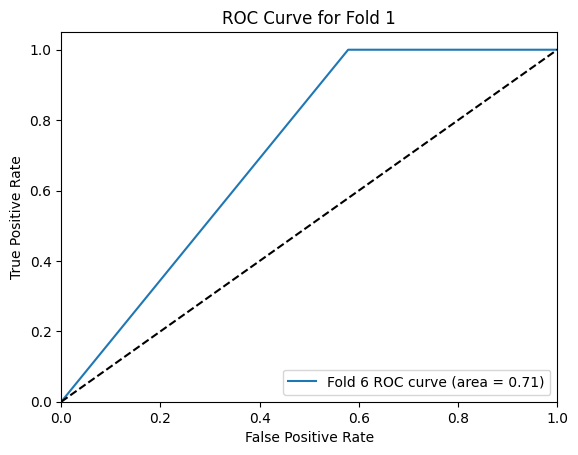

In [21]:
from sklearn.metrics import roc_curve

# Calculate ROC curve and ROC AUC for this fold
fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predicted_labels)

# Save the ROC curve data for each fold
np.save(f'tpr_fold6_RNN.npy', tpr)
np.save(f'fpr_fold6_RNN.npy', fpr)
np.save(f'roc_auc_fold6_RNN.npy', roc_auc)

# Now you can load the saved TPR and FPR arrays and use them to plot ROC curves
# Example of loading and plotting the ROC curve for the first fold
tpr = np.load('tpr_fold6_RNN.npy')
fpr = np.load('fpr_fold6_RNN.npy')
roc_auc = np.load('roc_auc_fold6_RNN.npy')

plt.figure()
plt.plot(fpr, tpr, label=f'Fold 6 ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fold 1')
plt.legend(loc="lower right")
plt.show()